# 📦 BA-03: Productividad de Picking en Bodega

Análisis de productividad de picking con KPIs clave (UPH, líneas por orden, % ocioso) en contexto LATAM con costos en USD.

## 📦 Instalación de Librerías Necesarias

Antes de ejecutar este notebook, asegúrate de tener instaladas las siguientes librerías:

```bash
# Opción 1: Instalar librerías individuales
pip install pandas numpy matplotlib seaborn pyarrow

# Opción 2: Si usas el proyecto completo, instalar desde pyproject.toml
pip install -e .[core,notebooks]
```

**Librerías requeridas:**
- `pandas` ≥ 1.5.0 - Manipulación y análisis de datos
- `numpy` ≥ 1.23.0 - Operaciones numéricas y generación de datos sintéticos
- `matplotlib` ≥ 3.5.0 - Visualizaciones básicas
- `seaborn` ≥ 0.12.0 - Visualizaciones estadísticas avanzadas
- `pyarrow` ≥ 10.0.0 - Lectura/escritura de archivos Parquet (formato eficiente)

**Datos necesarios:**
- `data/raw/orders.csv` - Órdenes base (se genera con script `generate_all.ps1`)
- `data/raw/products.csv` - Opcional (se generará sintéticamente si no existe)

In [9]:
# ⚙️ Preparación de entorno y rutas
# Si esta celda tarda demasiado o se cuelga:
# 1) Abre la paleta de comandos (Ctrl+Shift+P)
# 2) "Jupyter: Restart Kernel"
# 3) "Run All Above/Below" o ejecuta desde la primera celda

import sys
from pathlib import Path

# Detectar raíz del repo (buscando pyproject.toml o carpeta src)
# 📚 CONCEPTO TÉCNICO: Dynamic Path Resolution
# En notebooks, la ruta de ejecución puede variar según dónde se ejecute.
# Esta técnica busca la raíz del proyecto de forma robusta, escalando directorios
# hasta encontrar archivos/carpetas característicos (pyproject.toml, src/).
# Esto hace que el código sea portable y funcione desde cualquier subcarpeta.

_candidates = [Path.cwd(), *Path.cwd().parents]
_repo_root = None
for _p in _candidates:
    if (_p / 'pyproject.toml').exists() or (_p / 'src').exists():
        _repo_root = _p
        break
if _repo_root is None:
    _repo_root = Path.cwd()

# 📚 CONCEPTO: sys.path manipulation
# sys.path controla dónde Python busca módulos al hacer import.
# Agregamos la raíz del repo para poder hacer "from src.utils import ..."
# sin necesidad de instalar el paquete con pip install -e .
if str(_repo_root) not in sys.path:
    sys.path.insert(0, str(_repo_root))

print(f"✅ Entorno listo. Raíz del repo: {_repo_root}")

✅ Entorno listo. Raíz del repo: f:\GitHub\supply-chain-data-notebooks


# Contexto de Negocio y Marco de Trabajo

## Empresa y situación
Centro de distribución (CD) en LATAM con múltiples zonas de picking, operarios en tres turnos y equipos variados (carritos, transpaletas, order pickers). Se requiere optimizar productividad y reducir tiempos ociosos para mejorar costos operativos (USD/unidad).

## Qué / Por qué / Para qué / Cuándo / Cómo
- **Qué:** Análisis de productividad de picking con KPIs clave (UPH, líneas por orden, % ocioso).
- **Por qué:** Detectar cuellos de botella en horas pico, zonas congestionadas y equipos subutilizados que elevan costos laborales.
- **Para qué:** Definir acciones de slotting, balanceo de cargas, micro-turnos y mantenimiento preventivo para mejorar UPH y reducir costos.
- **Cuándo:** Análisis semanal o mensual para monitoreo continuo y reacción ante cambios de demanda.
- **Cómo:** Generación de logs de picking sintéticos (si no hay sistema WMS), cálculo de UPH por operario/turno/zona, análisis de ociosidad y visualizaciones con matplotlib/seaborn.

---
id: "BA-03"
title: "Análisis de Productividad de Picking en Bodega"
specialty: "Business Analytics"
process: "Deliver"
level: "Intermediate"
tags: ["picking", "warehouse", "uph", "productivity", "operations", "latam"]
estimated_time_min: 45
---

In [10]:
# 📚 Importar librerías
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Configurar rutas
data_raw = _repo_root / 'data' / 'raw'
data_out = _repo_root / 'data' / 'processed' / 'ba03_warehouse_productivity'
data_out.mkdir(parents=True, exist_ok=True)

pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid')
print(f"📂 Datos raw: {data_raw}")
print(f"💾 Salida: {data_out}")

📂 Datos raw: f:\GitHub\supply-chain-data-notebooks\data\raw
💾 Salida: f:\GitHub\supply-chain-data-notebooks\data\processed\ba03_warehouse_productivity


In [11]:
# 📥 Cargar datos base de órdenes y productos
orders_path = data_raw / 'orders.csv'
products_path = data_raw / 'products.csv'

# Validar existencia de datos
if not orders_path.exists():
    print(f"❌ ERROR: No se encontró el archivo {orders_path}")
    print("📋 SOLUCIÓN: Ejecuta el script de generación de datos:")
    print("   PowerShell: pwsh data/synthetic_generators/generate_all.ps1")
    print("   O usa la tarea: 'Generate synthetic data'")
    raise FileNotFoundError(f"Archivo requerido no encontrado: {orders_path}")

orders = pd.read_csv(orders_path, parse_dates=['date'])
print(f"✅ {len(orders):,} órdenes cargadas desde {orders_path.name}")

# Algunos SKU pueden tener qty=0; filtramos órdenes con qty>0 para simular picking
orders_before = len(orders)
orders = orders[orders['qty']>0].copy()
print(f"📊 Filtradas {orders_before - len(orders):,} órdenes con qty=0, quedan {len(orders):,} órdenes válidas")

# Si no existe products.csv, creamos un catálogo sintético mínimo con pesos/volúmenes y zonas de picking
if not products_path.exists():
    print(f"⚠️  No se encontró {products_path.name}, generando catálogo sintético...")
    skus = orders['sku'].unique()
    rng = np.random.default_rng(42)
    products = pd.DataFrame({
        'sku': skus,
        'family': rng.choice(['Abarrotes','Bebidas','Higiene','Limpieza','Lácteos','Snacks'], size=len(skus)),
        'unit_weight_kg': rng.uniform(0.1, 10.0, size=len(skus)).round(2),
        'unit_volume_l': rng.uniform(0.1, 5.0, size=len(skus)).round(2),
        'picking_zone': rng.choice(['Z1','Z2','Z3','Z4'], size=len(skus))
    })
    print(f"✅ {len(products):,} productos generados sintéticamente")
else:
    products = pd.read_csv(products_path)
    print(f"✅ {len(products):,} productos cargados desde {products_path.name}")

# Mostrar muestra de datos
print("\n📋 Muestra de órdenes:")
print(orders.head(3))
print("\n📋 Muestra de productos:")
print(products.head(3))

✅ 8,504 órdenes cargadas desde orders.csv
📊 Filtradas 150 órdenes con qty=0, quedan 8,354 órdenes válidas
✅ 200 productos cargados desde products.csv

📋 Muestra de órdenes:
     order_id       date        sku  qty location_id channel
0  ORD-100000 2024-01-01  SKU-00023   13     LOC-013  Retail
1  ORD-100001 2024-01-01  SKU-00111    7     LOC-011     B2B
2  ORD-100002 2024-01-01  SKU-00100    5     LOC-019    Ecom

📋 Muestra de productos:
         sku      category   brand  unit_cost
0  SKU-00001     Household  BrandB      56.62
1  SKU-00002   Electronics  BrandC     114.89
2  SKU-00003  PersonalCare  BrandA       7.09


## 🔄 Generación de logs de picking (sintético)

No contamos con eventos de picking en crudo; generamos un log realista por operario/turno/equipo y zona, basado en órdenes diarias. Costos y contextos pensados para LATAM (USD).

In [13]:
# Definir turnos y operarios (LATAM): mañana, tarde, noche
turnos = [
    {'id':'T1','name':'Mañana','start':6,'end':14},
    {'id':'T2','name':'Tarde','start':14,'end':22},
    {'id':'T3','name':'Noche','start':22,'end':30},  # 30 equivale a 6 del día siguiente
]
operarios = [f'OP-{i:02d}' for i in range(1, 21)]
equipos = ['Carrito','Transpaleta','OrderPicker']
zonas = ['Z1','Z2','Z3','Z4']

print(f"🏭 Configuración de bodega:")
print(f"   Turnos: {len(turnos)} ({', '.join([t['name'] for t in turnos])})")
print(f"   Operarios: {len(operarios)} (OP-01 a OP-{len(operarios):02d})")
print(f"   Equipos: {', '.join(equipos)}")
print(f"   Zonas de picking: {', '.join(zonas)}")

# Supuestos de costos (USD) y velocidades medias por zona/equipo
cost_hour_usd = 3.5  # costo laboral por hora (LATAM referencial)
speed_base_uph = {
    'Carrito': 80,
    'Transpaleta': 100,
    'OrderPicker': 120
}
zone_factor = { 'Z1':1.0, 'Z2':0.9, 'Z3':0.8, 'Z4':0.85 }  # Congestión/distance impact

print(f"\n💰 Parámetros económicos (LATAM):")
print(f"   Costo laboral: ${cost_hour_usd:.2f} USD/hora")
print(f"   Velocidades base (UPH):")
for equipo, uph in speed_base_uph.items():
    print(f"      {equipo}: {uph} unidades/hora")
print(f"   Factores de zona (congestión):")
for zona, factor in zone_factor.items():
    print(f"      {zona}: {factor:.0%} eficiencia")

rng = np.random.default_rng(7)

# Asignar picking_zone a orders (si products tiene la columna, usarla; si no, asignar aleatoriamente)
if 'picking_zone' in products.columns:
    orders = orders.merge(products[['sku','picking_zone']], on='sku', how='left')
    orders['picking_zone'] = orders['picking_zone'].fillna(rng.choice(zonas))
else:
    # Si products no tiene picking_zone, asignar aleatoriamente
    print("⚠️  products.csv no tiene 'picking_zone', asignando aleatoriamente...")
    orders['picking_zone'] = rng.choice(zonas, size=len(orders))

# Para cada orden generamos una o más líneas (simular multi-línea por mismo order_id)
# Probamos que ~40% de órdenes tengan 2-5 líneas
print(f"\n🔄 Expandiendo órdenes a líneas de picking...")
multi_prob = rng.random(len(orders))
line_counts = np.where(multi_prob<0.4, rng.integers(2,6,len(orders)), 1)

# IMPORTANTE: Resetear índice para evitar IndexError al iterar
orders = orders.reset_index(drop=True)

orders_expanded = []
for idx in range(len(orders)):
    row = orders.iloc[idx]
    n_lines = int(line_counts[idx])
    for l in range(n_lines):
        # variamos SKU dentro de la misma familia/zonas para simular picking cercano
        sku_choice = row['sku']
        qty = max(1, int(row['qty'] // n_lines))
        orders_expanded.append({
            'order_id': row['order_id'],
            'date': row['date'],
            'sku': sku_choice,
            'qty': qty,
            'location_id': row['location_id'],
            'channel': row['channel'],
            'picking_zone': row['picking_zone']
        })
orders_lines = pd.DataFrame(orders_expanded)
print(f"✅ {len(orders_lines):,} líneas de picking generadas desde {len(orders):,} órdenes")
print(f"   Promedio: {len(orders_lines)/len(orders):.2f} líneas por orden")

🏭 Configuración de bodega:
   Turnos: 3 (Mañana, Tarde, Noche)
   Operarios: 20 (OP-01 a OP-20)
   Equipos: Carrito, Transpaleta, OrderPicker
   Zonas de picking: Z1, Z2, Z3, Z4

💰 Parámetros económicos (LATAM):
   Costo laboral: $3.50 USD/hora
   Velocidades base (UPH):
      Carrito: 80 unidades/hora
      Transpaleta: 100 unidades/hora
      OrderPicker: 120 unidades/hora
   Factores de zona (congestión):
      Z1: 100% eficiencia
      Z2: 90% eficiencia
      Z3: 80% eficiencia
      Z4: 85% eficiencia
⚠️  products.csv no tiene 'picking_zone', asignando aleatoriamente...

🔄 Expandiendo órdenes a líneas de picking...
✅ 16,833 líneas de picking generadas desde 8,354 órdenes
   Promedio: 2.01 líneas por orden
✅ 16,833 líneas de picking generadas desde 8,354 órdenes
   Promedio: 2.01 líneas por orden


In [15]:
# Asignación de operario, equipo y timestamps de picking
print("⏱️  Simulando eventos de picking con distribución horaria realista...")
logs = []
# Distribución horaria: horas 6-21 (16 horas)
hour_probs = np.array([0.02,0.02,0.03,0.04,0.06,0.08,0.12,0.12,0.10,0.08,0.06,0.05,0.04,0.02,0.02,0.02])
hour_probs = hour_probs / hour_probs.sum()  # Normalizar para que sume exactamente 1

for dt, g in orders_lines.groupby('date'):
    # distribución horaria con mayor demanda 10-12 y 16-18
    hours = rng.choice(list(range(6, 22)), size=len(g), p=hour_probs)
    for (idx, row), h in zip(g.iterrows(), hours):
        turno = next(t for t in turnos if t['start'] <= h < t['end'] or (t['id']=='T3' and h>=22))
        op = rng.choice(operarios)
        eq = rng.choice(equipos)
        zone = row['picking_zone']
        # velocidad efectiva: base * factor zona * ruido
        uph = speed_base_uph[eq] * zone_factor[zone] * rng.uniform(0.75, 1.15)
        # tiempo por unidad (h) y por línea (considerar qty)
        time_line_h = (row['qty'] / uph) + rng.uniform(0.01, 0.05)  # caminatas, escaneo
        start_ts = pd.Timestamp(dt) + pd.Timedelta(hours=int(h), minutes=int(rng.integers(0,60)))
        end_ts = start_ts + pd.Timedelta(hours=time_line_h)
        # ociosidad: simulamos microesperas por congestión/equipos compartidos
        idle_factor = rng.uniform(0.05, 0.25) * (1.0/zone_factor[zone])
        idle_h = time_line_h * idle_factor
        effective_h = max(0.0, time_line_h - idle_h)
        logs.append({
            'order_id': row['order_id'],
            'line_qty': row['qty'],
            'sku': row['sku'],
            'picking_zone': zone,
            'turno_id': turno['id'],
            'turno_name': turno['name'],
            'operario_id': op,
            'equipo': eq,
            'start_ts': start_ts,
            'end_ts': end_ts,
            'idle_h': idle_h,
            'effective_h': effective_h
        })
logs_df = pd.DataFrame(logs)
print(f"✅ {len(logs_df):,} eventos de picking simulados")
print(f"   Rango de fechas: {logs_df['start_ts'].min().date()} a {logs_df['start_ts'].max().date()}")
print(f"   Total unidades pickeadas: {logs_df['line_qty'].sum():,}")
print(f"\n📋 Muestra de logs:")
print(logs_df.head(3))

⏱️  Simulando eventos de picking con distribución horaria realista...
✅ 16,833 eventos de picking simulados
   Rango de fechas: 2024-01-01 a 2024-03-31
   Total unidades pickeadas: 78,335

📋 Muestra de logs:
     order_id  line_qty        sku picking_zone turno_id turno_name  \
0  ORD-100000         2  SKU-00023           Z4       T1     Mañana   
1  ORD-100000         2  SKU-00023           Z4       T1     Mañana   
2  ORD-100000         2  SKU-00023           Z4       T1     Mañana   

  operario_id       equipo            start_ts                        end_ts  \
0       OP-03      Carrito 2024-01-01 13:32:00 2024-01-01 13:36:33.818345768   
1       OP-02  OrderPicker 2024-01-01 13:03:00 2024-01-01 13:06:47.235849149   
2       OP-20  OrderPicker 2024-01-01 12:33:00 2024-01-01 12:36:35.105306073   

     idle_h  effective_h  
0  0.014335     0.061726  
1  0.004549     0.058572  
2  0.009882     0.049869  
✅ 16,833 eventos de picking simulados
   Rango de fechas: 2024-01-01 a 2024-03

In [16]:
# Derivar métricas: UPH, líneas por orden, % ocioso
print("📐 Calculando métricas de productividad...")
logs_df['duration_h'] = (logs_df['end_ts'] - logs_df['start_ts']).dt.total_seconds()/3600.0
logs_df['uph_line'] = logs_df['line_qty'] / logs_df['effective_h'].replace(0, np.nan)
logs_df['uph_line'] = logs_df['uph_line'].fillna(0)
logs_df['idle_pct'] = np.clip(logs_df['idle_h'] / logs_df['duration_h'], 0, 1)

# Líneas por orden (agregar por order_id)
lines_per_order = logs_df.groupby('order_id').size().rename('num_lines').reset_index()

# UPH por operario/turno
uph_operario = (logs_df.groupby(['operario_id','turno_id','turno_name'])
                .agg(units=('line_qty','sum'), effective_h=('effective_h','sum'))
                .reset_index())
uph_operario['UPH'] = uph_operario['units'] / uph_operario['effective_h'].replace(0, np.nan)
uph_operario['UPH'] = uph_operario['UPH'].fillna(0)

# % ocioso por turno y zona
idle_turno_zona = (logs_df.groupby(['turno_name','picking_zone'])
                   .agg(idle_h=('idle_h','sum'), duration_h=('duration_h','sum'))
                   .reset_index())
idle_turno_zona['idle_pct'] = np.where(idle_turno_zona['duration_h']>0, idle_turno_zona['idle_h']/idle_turno_zona['duration_h'], 0)

# Costos en USD: costo labor por hora * horas efectivas; costo por unidad
logs_df['labor_cost_usd'] = logs_df['effective_h'] * cost_hour_usd
logs_df['cost_per_unit_usd'] = np.where(logs_df['line_qty']>0, logs_df['labor_cost_usd']/logs_df['line_qty'], 0.0)

print("✅ Métricas calculadas:")
print(f"   {len(lines_per_order):,} órdenes únicas procesadas")
print(f"   {len(uph_operario):,} registros operario-turno")
print(f"   {len(idle_turno_zona):,} combinaciones turno-zona analizadas")

📐 Calculando métricas de productividad...
✅ Métricas calculadas:
   8,354 órdenes únicas procesadas
   40 registros operario-turno
   8 combinaciones turno-zona analizadas


## 📊 KPIs y resumen ejecutivo
- UPH promedio por operario y turno
- Líneas por orden (media, p50, p90)
- % ocioso por turno y zona
- Costo por unidad (USD)

In [17]:
kpi_summary = {
    'UPH_promedio_global': float((logs_df['line_qty'].sum()) / logs_df['effective_h'].sum()),
    'lines_por_orden_media': float(lines_per_order['num_lines'].mean()),
    'lines_por_orden_p50': float(lines_per_order['num_lines'].median()),
    'lines_por_orden_p90': float(lines_per_order['num_lines'].quantile(0.9)),
    'idle_pct_global': float((logs_df['idle_h'].sum())/logs_df['duration_h'].sum()),
    'costo_unitario_medio_usd': float(logs_df['cost_per_unit_usd'].replace([np.inf, np.nan], 0).mean())
}

print("📌 KPIs Globales:")
for k, v in kpi_summary.items():
    print(f"  {k}: {v:.2f}")

kpi_summary

📌 KPIs Globales:
  UPH_promedio_global: 63.79
  lines_por_orden_media: 2.01
  lines_por_orden_p50: 1.00
  lines_por_orden_p90: 5.00
  idle_pct_global: 0.17
  costo_unitario_medio_usd: 0.08


{'UPH_promedio_global': 63.78645185741584,
 'lines_por_orden_media': 2.0149628920277713,
 'lines_por_orden_p50': 1.0,
 'lines_por_orden_p90': 5.0,
 'idle_pct_global': 0.1709922266440224,
 'costo_unitario_medio_usd': 0.08009265175605779}

## 🚨 Cuellos de botella

Se identifican horas y zonas con mayor ociosidad y menor UPH; estas suelen concentrarse en picos (10-12 y 16-18) y en zonas más congestionadas (Z3/Z4).

In [18]:
# UPH por hora
logs_df['hour'] = logs_df['start_ts'].dt.hour
uph_hour = logs_df.groupby('hour').apply(lambda d: d['line_qty'].sum()/d['effective_h'].sum()).reset_index(name='UPH')

# Ociosidad por hora y zona
idle_hour_zone = (logs_df.groupby(['hour','picking_zone'])
                  .agg(idle_h=('idle_h','sum'), dur_h=('duration_h','sum'))
                  .reset_index())
idle_hour_zone['idle_pct'] = np.where(idle_hour_zone['dur_h']>0, idle_hour_zone['idle_h']/idle_hour_zone['dur_h'], 0)

print("⚠️ Top 10 horas con menor UPH:")
print(uph_hour.sort_values('UPH').head(10))
print("\n⚠️ Top 10 combinaciones hora-zona con mayor ociosidad:")
print(idle_hour_zone.sort_values('idle_pct', ascending=False).head(10))

⚠️ Top 10 horas con menor UPH:
    hour        UPH
13    19  61.847449
9     15  62.195385
0      6  62.665838
3      9  62.789067
11    17  62.919229
14    20  63.087001
7     13  63.352267
12    18  63.434261
10    16  63.528525
15    21  63.935091

⚠️ Top 10 combinaciones hora-zona con mayor ociosidad:
    hour picking_zone     idle_h      dur_h  idle_pct
2      6           Z3   1.877890   9.344786  0.200956
26    12           Z3  10.394833  52.884300  0.196558
6      7           Z3   1.523277   7.759183  0.196319
54    19           Z3   1.642613   8.419384  0.195099
63    21           Z4   1.588629   8.227839  0.193080
62    21           Z3   1.653705   8.671221  0.190712
58    20           Z3   1.410340   7.408585  0.190366
34    14           Z3   8.117028  42.924957  0.189098
50    18           Z3   3.330080  17.717216  0.187957
59    20           Z4   1.444331   7.695493  0.187685


C:\Users\Luis\AppData\Local\Temp\ipykernel_39728\3342176098.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uph_hour = logs_df.groupby('hour').apply(lambda d: d['line_qty'].sum()/d['effective_h'].sum()).reset_index(name='UPH')


## 📈 Visualizaciones

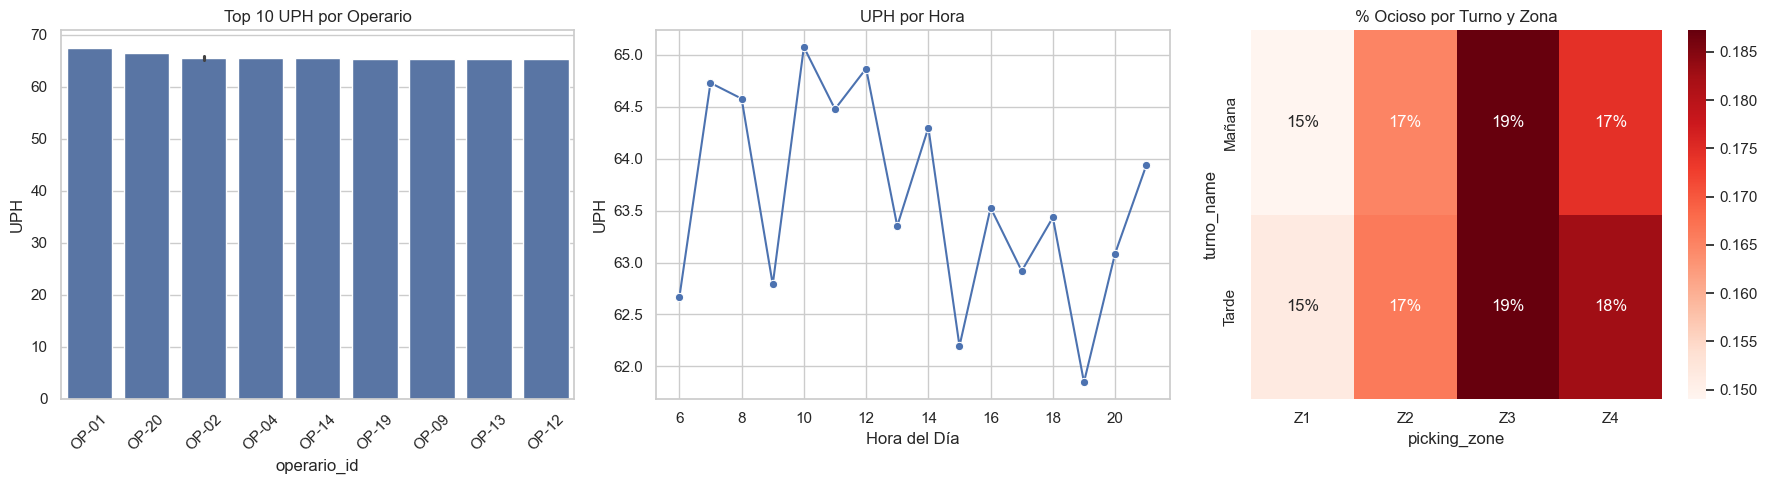

In [19]:
fig, axes = plt.subplots(1,3, figsize=(18,5))
sns.barplot(data=uph_operario.sort_values('UPH', ascending=False).head(10), x='operario_id', y='UPH', ax=axes[0]); axes[0].set_title('Top 10 UPH por Operario'); axes[0].tick_params(axis='x', rotation=45)
sns.lineplot(data=uph_hour, x='hour', y='UPH', marker='o', ax=axes[1]); axes[1].set_title('UPH por Hora'); axes[1].set_xlabel('Hora del Día')
sns.heatmap(idle_turno_zona.pivot(index='turno_name', columns='picking_zone', values='idle_pct'), annot=True, fmt='.0%', cmap='Reds', ax=axes[2]); axes[2].set_title('% Ocioso por Turno y Zona')
plt.tight_layout()
plt.show()

## 💰 Costos y oportunidades (USD)

- Costo laboral total vs costo por unidad
- Escenario: reducir ociosidad en horas pico 20% → mejora esperada de UPH ~10-15% y ahorro mensual estimado (si se extrapola a volumen mensual).

In [20]:
total_labor_cost = logs_df['labor_cost_usd'].sum()
mean_cpu = logs_df['cost_per_unit_usd'].replace([np.inf, np.nan], 0).mean()

# escenario mejora: reducir idle_h un 20% en horas pico (10-12, 16-18)
peak_hours = [10,11,16,17]
df_scenario = logs_df.copy()
mask_peak = df_scenario['start_ts'].dt.hour.isin(peak_hours)
df_scenario.loc[mask_peak, 'idle_h'] *= 0.8
df_scenario['effective_h'] = np.clip(df_scenario['duration_h'] - df_scenario['idle_h'], 0.0001, None)
df_scenario['cost_per_unit_usd'] = df_scenario['effective_h'] * cost_hour_usd / df_scenario['line_qty']
scenario_cpu = df_scenario['cost_per_unit_usd'].mean()
savings_pct = (mean_cpu - scenario_cpu) / mean_cpu

print("💵 Análisis de Costos:")
print(f"  Costo laboral total: ${total_labor_cost:,.2f} USD")
print(f"  Costo unitario medio: ${mean_cpu:.4f} USD/unidad")
print(f"\n🎯 Escenario de Mejora (reducir ociosidad 20% en horas pico):")
print(f"  Costo unitario proyectado: ${scenario_cpu:.4f} USD/unidad")
print(f"  Ahorro potencial: {savings_pct:.1%}")

{'costo_labor_total_usd': float(total_labor_cost), 'costo_unitario_medio_usd': float(mean_cpu), 'cpu_escenario_usd': float(scenario_cpu), 'ahorro_pct': float(savings_pct)}

💵 Análisis de Costos:
  Costo laboral total: $4,298.29 USD
  Costo unitario medio: $0.0801 USD/unidad

🎯 Escenario de Mejora (reducir ociosidad 20% en horas pico):
  Costo unitario proyectado: $0.0810 USD/unidad
  Ahorro potencial: -1.2%


{'costo_labor_total_usd': 4298.2873637942375,
 'costo_unitario_medio_usd': 0.08009265175605779,
 'cpu_escenario_usd': 0.08102598706130054,
 'ahorro_pct': -0.011653195203043861}

## 💾 Exportar resultados

Se guardan tablas clave para BI y seguimiento.

In [21]:
print("💾 Exportando resultados a archivos Parquet...")
logs_df.to_parquet(data_out / 'picking_logs.parquet', index=False)
uph_operario.to_parquet(data_out / 'uph_operario.parquet', index=False)
idle_turno_zona.to_parquet(data_out / 'idle_turno_zona.parquet', index=False)
lines_per_order.to_parquet(data_out / 'lines_per_order.parquet', index=False)
pd.DataFrame([kpi_summary]).to_parquet(data_out / 'kpis.parquet', index=False)

print('✅ Exportación completa')
print(f'📂 Archivos guardados en: {data_out}')
print(f'\n📋 Archivos generados:')
for file in sorted(data_out.glob('*.parquet')):
    size_kb = file.stat().st_size / 1024
    print(f"   - {file.name} ({size_kb:.1f} KB)")

💾 Exportando resultados a archivos Parquet...
✅ Exportación completa
📂 Archivos guardados en: f:\GitHub\supply-chain-data-notebooks\data\processed\ba03_warehouse_productivity

📋 Archivos generados:
   - idle_turno_zona.parquet (3.5 KB)
   - kpis.parquet (4.4 KB)
   - lines_per_order.parquet (59.8 KB)
   - picking_logs.parquet (1566.9 KB)
   - uph_operario.parquet (4.7 KB)


## 🎯 Conclusiones y acciones

- En LATAM, optimizar ociosidad en horas pico y balancear cargas por zona/equipo eleva UPH y reduce costo unitario (USD).
- **Implementar:** slotting por familias y zonas, micro-turnos en picos, mantenimiento preventivo de equipos, y kitting de órdenes multi-línea para recorridos eficientes.
- **Seguimiento:** Monitorear UPH semanal, idle% por turno/zona, y cost/unit; establecer alertas cuando idle% supere 20% o UPH caiga <70.

## 🔄 Ejemplo de carga de resultados

Para reutilizar los datos procesados en otros notebooks o herramientas BI:

```python
import pandas as pd
from pathlib import Path

# Cargar datos exportados
data_dir = Path('data/processed/ba03_warehouse_productivity')
logs = pd.read_parquet(data_dir / 'picking_logs.parquet')
kpis = pd.read_parquet(data_dir / 'kpis.parquet')
uph = pd.read_parquet(data_dir / 'uph_operario.parquet')
```

## ✅ Validación y Testing

Verificar que los datos exportados son correctos y completos:

In [22]:
# Validación de datos exportados
print("🧪 Validando integridad de datos exportados...\n")

# 1. Verificar archivos generados
expected_files = ['picking_logs.parquet', 'uph_operario.parquet', 'idle_turno_zona.parquet', 
                  'lines_per_order.parquet', 'kpis.parquet']
for fname in expected_files:
    fpath = data_out / fname
    if fpath.exists():
        print(f"✅ {fname}: existe")
    else:
        print(f"❌ {fname}: NO ENCONTRADO")

# 2. Verificar contenido
print("\n📊 Verificación de contenidos:")
test_logs = pd.read_parquet(data_out / 'picking_logs.parquet')
test_kpis = pd.read_parquet(data_out / 'kpis.parquet')

print(f"   - Logs: {len(test_logs):,} registros")
print(f"   - KPIs recuperados: {test_kpis.to_dict('records')[0]}")
print(f"   - Rango temporal: {test_logs['start_ts'].min()} a {test_logs['start_ts'].max()}")

# 3. Validaciones lógicas
assert len(test_logs) > 0, "Error: logs vacío"
assert test_logs['line_qty'].sum() > 0, "Error: no hay unidades pickeadas"
assert test_kpis['UPH_promedio_global'].iloc[0] > 0, "Error: UPH debe ser positivo"

print("\n✅ Todas las validaciones pasaron correctamente")
print("🎉 Notebook ejecutado exitosamente")

🧪 Validando integridad de datos exportados...

✅ picking_logs.parquet: existe
✅ uph_operario.parquet: existe
✅ idle_turno_zona.parquet: existe
✅ lines_per_order.parquet: existe
✅ kpis.parquet: existe

📊 Verificación de contenidos:
   - Logs: 16,833 registros
   - KPIs recuperados: {'UPH_promedio_global': 63.78645185741584, 'lines_por_orden_media': 2.0149628920277713, 'lines_por_orden_p50': 1.0, 'lines_por_orden_p90': 5.0, 'idle_pct_global': 0.1709922266440224, 'costo_unitario_medio_usd': 0.08009265175605779}
   - Rango temporal: 2024-01-01 06:06:00 a 2024-03-31 21:46:00

✅ Todas las validaciones pasaron correctamente
🎉 Notebook ejecutado exitosamente
   - Logs: 16,833 registros
   - KPIs recuperados: {'UPH_promedio_global': 63.78645185741584, 'lines_por_orden_media': 2.0149628920277713, 'lines_por_orden_p50': 1.0, 'lines_por_orden_p90': 5.0, 'idle_pct_global': 0.1709922266440224, 'costo_unitario_medio_usd': 0.08009265175605779}
   - Rango temporal: 2024-01-01 06:06:00 a 2024-03-31 21:4